In [1]:
using Distributions, QuadGK, LinearAlgebra, Optim, Interpolations, Plots, Printf, ForwardDiff, PrettyTables, Distributed

In [2]:
# Truncated lognormal PDF and CDF functions
function truncated_lognormal(μₓ, σₓ)
    # Calculate log-space parameters
    μₓ_log = log(μₓ) - 0.5 * σₓ^2
    σₓ_log = sqrt(log(1 + (σₓ^2 / μₓ^2)))
    lognormal_dist = LogNormal(μₓ_log, σₓ_log)
    
    # Normalization factor
    cdf_low = cdf(lognormal_dist, 0)
    cdf_high = cdf(lognormal_dist, 1)
    normalization = cdf_high - cdf_low
    
    # PDF function ℓ(x)
    ℓ = x -> begin
        (x < 0 || x > 1) ? 0.0 : pdf(lognormal_dist, x) / normalization
    end
    
    # CDF function L(x)
    L = x -> begin
        if x < 0
            return 0.0
        elseif x > 1
            return 1.0
        end
        (cdf(lognormal_dist, x) - cdf_low) / normalization
    end
    
    return ℓ, L
end

# Uniform PDF function for γ(y)
function uniform_pdf(a, b)
    γ = y -> (a ≤ y ≤ b) ? b : a
    Γ = y -> clamp(y, a, b)  # CDF
    return γ, Γ
end

uniform_pdf (generic function with 1 method)

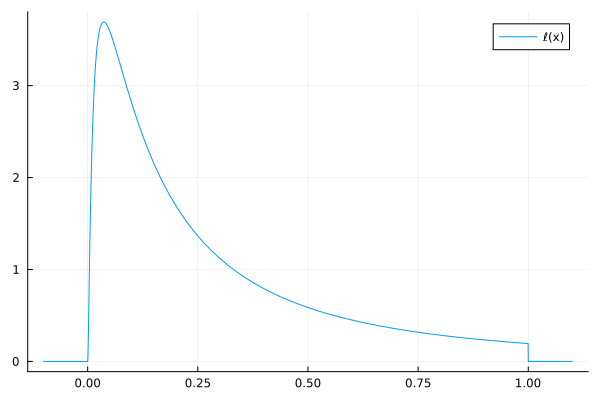

In [3]:
ℓ = truncated_lognormal(0.3, 0.7)[1]
plot(x ->ℓ(x), -0.1, 1.1, label="ℓ(x)", legend=:topright)

In [4]:
# Beta distribution PDF and CDF functions
function beta_dist(α, β; ϵ = 1e-8)
    beta_dist = Beta(α, β)

    # PDF function ℓ(x), clamped inside [ϵ, 1 - ϵ]
    ℓ = x -> begin
        (x < 0 || x > 1) ? 0.0 : pdf(beta_dist, clamp(x, ϵ, 1 - ϵ))
    end

    # CDF function L(x), clamped to [0,1]
    L = x -> begin
        if x < 0
            return 0.0
        elseif x > 1
            return 1.0
        end
        return cdf(beta_dist, x)
    end

    return ℓ, L
end

beta_dist (generic function with 1 method)

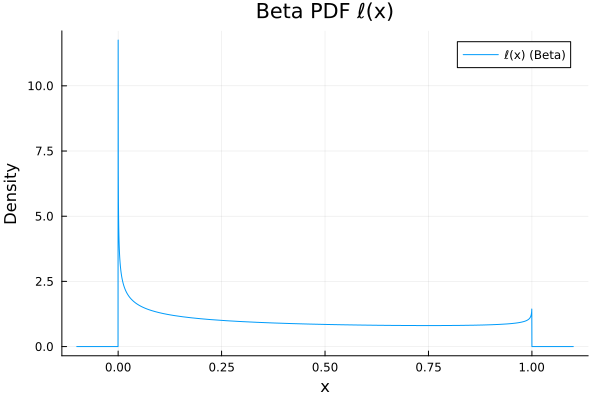

In [5]:
ℓ = beta_dist(0.7, 0.9)[1]  
plot(x -> ℓ(x), -0.1, 1.1, label="ℓ(x) (Beta)", legend=:topright,
     xlabel="x", ylabel="Density", title="Beta PDF ℓ(x)")

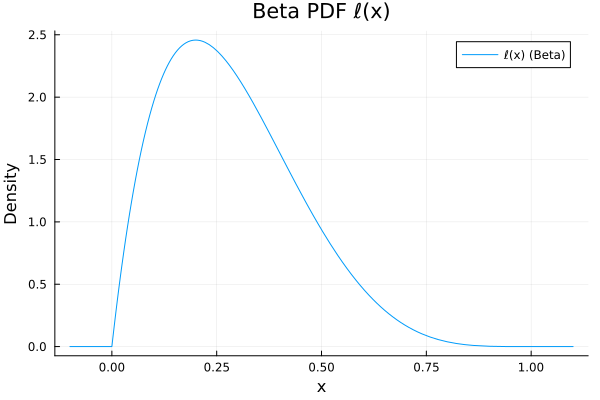

In [6]:
ℓ = beta_dist(2, 5)[1]
plot(x -> ℓ(x), -0.1, 1.1, label="ℓ(x) (Beta)", legend=:topright,
     xlabel="x", ylabel="Density", title="Beta PDF ℓ(x)")

In [7]:
Base.@kwdef mutable struct ModelParameters
    r::Float64       # Discount rate
    δ::Float64       # Productivity shock rate
    ξ::Float64       # Job separation rate
    β::Float64       # Worker's bargaining power
    b::Float64       # Unemployment benefit
    s::Float64       # Search intensity of employed workers
    η::Float64       # Matching efficiency
    c::Float64       # Vacancy posting cost
    ρ::Float64       # CES parameter
    α::Float64       # CES weight
    A::Float64       # Productivity scale
    aₓ::Float64      # Worker ability dist parameter
    bₓ::Float64      # Worker ability dist parameter
    a_y::Float64     # Firm productivity dist parameter
    b_y::Float64     # Firm productivity dist parameter
end

mutable struct ModelGrids
    x_grid::Vector{Float64}  # Worker ability grid (fixed [0,1])
    y_γ_grid::Vector{Float64} # Grid for γ(y) (fixed [0,1])
    y_n_grid::Vector{Float64} # Grid for n(y) (scales with N)
end

struct ModelDistributions
    ℓ::Function     # Worker ability PDF ℓ(x)
    L::Function     # Worker ability CDF L(x)
    γ::Function     # Firm productivity PDF γ(y)
    Γ::Function     # Firm productivity CDF Γ(y)
end

mutable struct ModelState
    S::Matrix{Float64}       # Surplus function S(x,y)
    h::Matrix{Float64}       # Match distribution h(x,y)
    u::Vector{Float64}       # Unemployment distribution u(x)
    v::Vector{Float64}       # Vacancy distribution v(y)
    n::Vector{Float64}       # Firm distribution n(y)
    κ::Float64               # Market tightness
    N::Float64               # Total number of firms
    W0::Vector{Float64}      # Value of unemployment
    Π0::Vector{Float64}      # Value of vacancy
end

In [241]:
function initialize_model(;
    r=0.05, δ=0.1, ξ=0.15, β=0.5, b=0.1, s=0.5, η=1.0, c=0.1, 
    ρ=0.5, α=0.5, A=1.0, nx=50, n_γ=50, n_n=50, aₓ=2, bₓ=5, a_y =2, b_y=5)
    
    params = ModelParameters(;
        r=r, δ=δ, ξ=ξ, β=β, b=b, s=s, η=η, c=c, ρ=ρ, α=α, A=A,
        aₓ=aₓ, bₓ=bₓ, a_y=a_y, b_y=b_y
    )
    
    # Initialize grids
    x_grid = collect(range(0.0, 1.0, length=nx))
    y_γ_grid = collect(range(0.0, 1.0, length=n_γ))
    y_n_grid = collect(range(0.0, 1.0, length=n_n))
    grids = ModelGrids(x_grid, y_γ_grid, y_n_grid)

    # Initialize distribution functions
    ℓ, L = beta_dist(aₓ, bₓ)
    γ, Γ = beta_dist(a_y, b_y)
    #γ, Γ = uniform_pdf(0.0, 1.0)
    dists = ModelDistributions(ℓ, L, γ, Γ)
    
    # Initialize state variables
    S = zeros(nx, n_n)
    h = zeros(nx, n_n)
    κ = 0.01  # Initial market tightness
    u = dists.ℓ.(grids.x_grid)  # Initialize u(x) using ℓ(x)
    
    # Initialize n(y) = N*γ(y) and vacancies v(y)
    n = zeros(n_n)
    v = zeros(n_n)
    N = 1.0  # Initial total firms
    
    # Initial value functions
    W0 = zeros(nx)
    Π0 = zeros(n_n)

    state = ModelState(S, h, u, v, n, κ, N, W0, Π0)

    state, params, grids, dists
end

initialize_model (generic function with 1 method)

In [ ]:
function update_u_v_n(state, params, grids, dists; tol=1e-6, max_iter=100, verbose=true)
    # Get grid spacing
    Δx = grids.x_grid[2] - grids.x_grid[1]
    Δy = grids.y_γ_grid[2] - grids.y_γ_grid[1]
    Δn_y = grids.y_n_grid[2] - grids.y_n_grid[1]
    
    # Step 1: Calculate u(x) and U
    # u(x) = ℓ(x) - ∫h(x,y)dy
    state.u .= max.(0.0, dists.ℓ.(grids.x_grid) .- sum(state.h, dims=2) .* Δy)
    U = sum(state.u) * Δx
    
    # Step 2: Solve for V using matching function
    # V = η²/κ²(U+s(1-U))
    matches = U + params.s * max(0.0, 1 - U)
    V = (params.η^2) / (state.κ^2 * matches)

    # Step 3: Calculate N and update n(y), v(y)
    N = V + 1 - U
    state.N = max(1e-8, V + 1 - U)
    
    # n(y) = Nγ(y/N) since γ is defined on [0,1]
    state.n .= state.N .* dists.γ.(grids.y_γ_grid)
    #grids.y_n_grid .= grids.y_γ_grid .* state.N
    
    # v(y) = n(y) - ∫h(x,y)dx
    state.v .= max.(0.0, state.n .- sum(state.h, dims=1)' .* Δx)

    
    # Return key aggregates
    return state
end

update_u_v_n (generic function with 1 method)

In [319]:
function iterate_Π0!(
    state::ModelState,
    params::ModelParameters,
    grids::ModelGrids,
    dists::ModelDistributions;
    max_iter::Int = 100,
    tol::Float64 = 1e-6
)
    n_γ = length(grids.y_γ_grid)
    nx = length(grids.x_grid)
    n_n = length(grids.y_n_grid)
    Δx = grids.x_grid[2] - grids.x_grid[1]
    Δy_n = grids.y_n_grid[2] - grids.y_n_grid[1]
    Δy = grids.y_γ_grid[2] - grids.y_γ_grid[1]

    Π0 = copy(state.Π0)
    γ_pdf = [dists.γ(y) for y in grids.y_γ_grid]

    for iter in 1:max_iter
        Π0_new = similar(Π0)

        for y_idx in 1:n_γ
            y_val = grids.y_γ_grid[y_idx]

            ## --- Term 1: Posting cost ---
            term1 = -params.c

            ## --- Term 2: surplus with unemployed workers ---
            S_vec = similar(state.u)
            for x_idx in 1:nx
                S_interp = ces_utility(params, grids.x_grid[x_idx], y_val)
                S_val = max(S_interp - b(params, grids.x_grid[x_idx]) - state.W0[x_idx] - Π0[y_idx], 0.0)
                S_vec[x_idx] = S_val
            end
            term2 = (1 - params.β) * state.κ * sum(S_vec .* state.u) * Δx

            ## --- Term 3: poaching loss ---
            ΔS = similar(state.h)
            for x_idx in 1:nx
                S_interp = ces_utility(params, grids.x_grid[x_idx], y_val)
                for yj in 1:n_n
                    ΔS[x_idx, yj] = max(S_interp - state.S[x_idx, yj], 0.0)
                end
            end
            term3 = (1 - params.β) * state.κ * params.s * sum(ΔS .* state.h) * Δx * Δy

            ## --- Term 4: expected shock value ---
            term4 = params.δ * sum((Π0 .- Π0[y_idx]) .* γ_pdf) * Δy

            ## --- Combine terms ---
            Π0_new[y_idx] = (term1 + term2 + term3 + term4) / params.r
        end

        if maximum(abs.(Π0_new .- Π0)) < tol
            break
        end
        Π0 = Π0_new
    end

    state.Π0 .= Π0
end

function iterate_h!(
    state::ModelState,
    params::ModelParameters,
    grids::ModelGrids;
    tol::Float64 = 1e-6,
    max_iter::Int = 100
)
    Δy = grids.y_γ_grid[2] - grids.y_γ_grid[1]
    nx = length(grids.x_grid)
    ny = length(grids.y_γ_grid)

    for iter in 1:max_iter
        h_old = copy(state.h)
        h_new = similar(state.h)

        for x_idx in 1:nx
            S_row = view(state.S, x_idx, :)
            h_row_old = view(h_old, x_idx, :)
            h_total_x = sum(h_row_old) * Δy

            for y_idx in 1:ny
                S_xy = S_row[y_idx]
                if S_xy < 0
                    h_new[x_idx, y_idx] = 0.0
                    continue
                end

                B_mask = (S_row .>= 0.0) .& (S_row .< S_xy)
                V̄_mask = .!B_mask

                h_B = sum(h_row_old[B_mask]) * Δy
                V_B̄ = sum(state.v[V̄_mask]) * Δy

                numer = params.δ * h_total_x + (state.u[x_idx] + params.s * h_B) * state.κ * state.v[y_idx]
                denom = params.δ + params.ξ + params.s * state.κ * V_B̄

                h_new[x_idx, y_idx] = denom > tol ? numer / denom : 0.0
            end
        end

        if maximum(abs.(h_new .- h_old)) < tol
            state.h .= h_new
            return
        end

        state.h .= h_new
    end

    @warn "Maximum iterations reached in iterate_h! without convergence."
end


function iterate_S!(state::ModelState, params::ModelParameters, grids::ModelGrids, dists::ModelDistributions; tol::Float64 = 1e-6, max_iter::Int = 100)
    Δx = grids.x_grid[2] - grids.x_grid[1]
    Δy_n = grids.y_n_grid[2] - grids.y_n_grid[1]
    Δy_γ = grids.y_γ_grid[2] - grids.y_γ_grid[1]
    nx = length(grids.x_grid)
    n_n = length(grids.y_n_grid)

    γ_pdf = [dists.γ(y) for y in grids.y_γ_grid]

    for iter in 1:max_iter
        S_old = copy(state.S)
        S_new = similar(state.S)

        for ix in 1:nx
            S_row = view(S_old, ix, :)
            S_pos = max.(S_row, 0.0)
            f_row = [ces_utility(params, grids.x_grid[ix], y) for y in grids.y_n_grid]
            b_val = b(params, grids.x_grid[ix])
            u_x = state.u[ix]

            term1 = state.κ * params.β * sum(S_pos .* state.v) * Δy_n
            term5 = params.δ * sum(S_pos .* γ_pdf) * Δy_γ

            for iy in 1:n_n
                S_xy = S_row[iy]
                f_xy = f_row[iy]

                term2 = state.κ * (1 - params.β) * max(S_xy, 0.0) * u_x
                ΔS_mat = S_xy .- S_old
                ΔS_pos = max.(ΔS_mat, 0.0)
                term3 = params.s * state.κ * (1 - params.β) * sum(ΔS_pos .* state.h) * Δx * Δy_n

                ΔS_vec = max.(S_row .- S_xy, 0.0)
                term4 = params.β * params.s * state.κ * sum(ΔS_vec .* state.v) * Δy_n

                numerator = f_xy - b_val + params.c - term1 - term2 - term3 + term4 + term5
                denom = params.r + params.δ + params.ξ
                S_new[ix, iy] = numerator / denom
            end
        end

        if maximum(abs.(S_new .- S_old)) < tol
            break
        end
        state.S .= max.(S_new, 0.0)

        if iter == max_iter
            @warn "Maximum iterations reached in iterate_S! without convergence."
        end
    end
end

function iterate_kappa!(state::ModelState, params::ModelParameters, grids::ModelGrids, dists::ModelDistributions)
    Δx = grids.x_grid[2] - grids.x_grid[1]
    Δy_n = grids.y_n_grid[2] - grids.y_n_grid[1]
    Δy_γ = grids.y_γ_grid[2] - grids.y_γ_grid[1]

    y0_idx = argmin(abs.(grids.y_n_grid .- 0.0))
    S_x0 = max.(state.S[:, y0_idx], 0.0)
    term_den1 = sum(S_x0 .* state.u) * Δx

    ΔS = state.S[:, y0_idx] .- state.S
    ΔS_pos = max.(ΔS, 0.0)
    term_den2 = params.s * sum(ΔS_pos .* state.h) * Δx * Δy_n

    γ_pdf = [dists.γ(y) for y in grids.y_γ_grid]
    expectation_Π0 = sum(state.Π0 .* γ_pdf) * Δy_γ

    numerator_κ = params.c - params.δ * expectation_Π0
    denominator_κ = term_den1 + term_den2
    state.κ = numerator_κ / ((1 - params.β) * denominator_κ)
end

function update_kappa_h_S!(state::ModelState, params::ModelParameters,
                           grids::ModelGrids, dists::ModelDistributions;
                           tol::Float64 = 1e-8, max_iter_Π0::Int = 100, verbose::Bool = false)
    iterate_h!(state, params, grids; tol=tol)
    iterate_S!(state, params, grids, dists)
    iterate_Π0!(state, params, grids, dists)
    iterate_kappa!(state, params, grids, dists)
    return state
end

update_kappa_h_S! (generic function with 1 method)

In [320]:
state, params, grids, dists = initialize_model(nx=50, n_γ=50, n_n=50)
state = update_u_v_n(state, params, grids, dists)

ModelState([0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [2.9999998799999994e-7, 0.5637749875919217, 1.0364832353860496, 1.426571147123761, 1.7420110319116844, 1.9903138487011298, 2.178541950767517, 2.313321830189802, 2.4008568623299107, 2.44694005031216  …  0.027872176510586943, 0.01783547414449751, 0.010709823287915761, 0.005918536246692538, 0.002920609869079184, 0.0012234700251560796, 0.0003957160862614184, 7.986540441991122e-5, 5.0977917714836885e-6, 3.0000000302971166e-31], [0.0030015624551052358, 5640.686345238562, 10370.230963745138, 14273.141886735973, 17429.183729718156, 19913.505203664594, 21796.766626189, 23145.267432720833, 24021.073687680353, 24482.14559565348  …  278.8669396754904, 178.44763900831862, 107.1540158922262, 59.21618965948687, 29.221310932312097, 12.241072797826739, 3.9592219830470747, 0.799070029858139, 0.051004469990944976, 3.0015626054806367

In [321]:
matches = U + params.s * max(0.0, 1 - U)
V = (params.η^2) / (state.κ^2 * matches)

10034.68832164203

In [288]:
function iterate_Π0!(
    state::ModelState,
    params::ModelParameters,
    grids::ModelGrids,
    dists::ModelDistributions;
    max_iter::Int = 100,
    tol::Float64 = 1e-8
)
    n_γ = length(grids.y_γ_grid)
    nx = length(grids.x_grid)
    n_n = length(grids.y_n_grid)
    Δx = grids.x_grid[2] - grids.x_grid[1]
    Δy_n = grids.y_n_grid[2] - grids.y_n_grid[1]
    Δy_γ = grids.y_γ_grid[2] - grids.y_γ_grid[1]

    Π0 = copy(state.Π0)
    γ_pdf = [dists.γ(y) for y in grids.y_γ_grid]

    for iter in 1:max_iter
        Π0_new = similar(Π0)

        total_term2 = 0.0
        total_term3 = 0.0
        total_term4 = 0.0

        for y_idx in 1:n_γ
            y_val = grids.y_γ_grid[y_idx]

            term1 = -params.c

            # Term 2: surplus with unemployed workers
            S_vec = similar(state.u)
            for x_idx in 1:nx
                S_interp = ces_utility(params, grids.x_grid[x_idx], y_val)
                S_val = max(S_interp - b(params, grids.x_grid[x_idx]) - state.W0[x_idx] - Π0[y_idx], 0.0)
                S_vec[x_idx] = S_val
            end
            term2 = (1 - params.β) * state.κ * sum(S_vec .* state.u) * Δx

            # Term 3: poaching loss
            ΔS = similar(state.h)
            for x_idx in 1:nx
                S_interp = ces_utility(params, grids.x_grid[x_idx], y_val)
                for yj in 1:n_n
                    ΔS[x_idx, yj] = max(S_interp - state.S[x_idx, yj], 0.0)
                end
            end
            term3 = (1 - params.β) * state.κ * params.s * sum(ΔS .* state.h) * Δx * Δy_n

            # Term 4: expected shock value
            term4 = params.δ * sum((Π0 .- Π0[y_idx]) .* γ_pdf) * Δy_γ

            total_term2 += term2
            total_term3 += term3
            total_term4 += term4

            Π0_new[y_idx] = (term1 + term2 + term3 + term4) / params.r
        end

        println("Iteration: ", iter)
        println("Total term2 (unemp. match): ", total_term2)
        println("Total term3 (poaching): ", total_term3)
        println("Total term4 (shock value): ", total_term4)

        if maximum(abs.(Π0_new .- Π0)) < tol
            break
        end
        Π0 = Π0_new
    end

    state.Π0 .= Π0
end

iterate_Π0! (generic function with 1 method)

In [283]:
params.r, params.δ

(0.05, 0.1)

In [322]:
iterate_h!(state, params, grids; tol=1e-6)
iterate_S!(state, params, grids, dists; tol=1e-6)
iterate_Π0!(state, params, grids, dists; max_iter=100, tol=1e-6)

┌ Warning: Maximum iterations reached in iterate_S! without convergence.
└ @ Main /Users/ramzi.chariag/Documents/CEU/PhD/Research/Search and matching/code/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_Y102sZmlsZQ==.jl:162


50-element Vector{Float64}:
  2.118653236264434e29
  1.6924612695464733e29
  1.4853601411320182e29
  1.3143048594062317e29
  1.1619082809201387e29
  1.0214356420420412e29
  8.893281929660152e28
  7.583730848918498e28
  6.315952310992515e28
  5.091862267865488e28
  ⋮
 -2.4508857418283033e29
 -2.528839510356663e29
 -2.6064634749993132e29
 -2.683769075986983e29
 -2.7607671070608626e29
 -2.83746776549168e29
 -2.913880697230552e29
 -2.9900150377578085e29
 -3.0658794491215517e29

In [311]:
iterate_h!(state, params, grids; tol=1e-6)
iterate_S!(state, params, grids, dists; tol=1e-6)
iterate_Π0!(state, params, grids, dists; max_iter=100, tol=1e-6)
iterate_kappa!(state, params, grids, dists)

┌ Warning: Maximum iterations reached in iterate_S! without convergence.
└ @ Main /Users/ramzi.chariag/Documents/CEU/PhD/Research/Search and matching/code/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_Y102sZmlsZQ==.jl:162


-Inf

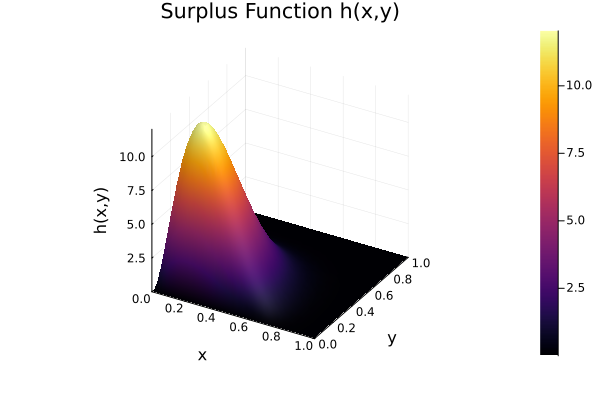

In [323]:
surface(grids.x_grid, grids.y_n_grid, state.h;
    xlabel = "x", ylabel = "y", zlabel = "h(x,y)",
    title = "Surplus Function h(x,y)")

In [325]:
int_h = sum(state.h, dims=2) * Δy
int_int_h = sum(int_h) * Δx

13.248865934111342

In [217]:
state.S

20×20 Matrix{Float64}:
 0.333333  0.377193  0.421053  …  1.03509  1.07895  1.12281  1.16667
 0.359649  0.491228  0.571422     1.41228  1.46694  1.52128  1.57534
 0.385965  0.553878  0.649123     1.58393  1.64307  1.70175  1.76004
 0.412281  0.608075  0.714868     1.72177  1.78434  1.84636  1.90788
 0.438596  0.657895  0.774423     1.84211  1.90756  1.97239  2.03665
 0.464912  0.704918  0.830024  …  1.95125  2.01926  2.08656  2.15323
 0.491228  0.749955  0.882816     2.05245  2.12276  2.19231  2.26115
 0.517544  0.793487  0.933479     2.14763  2.22006  2.29166  2.36251
 0.54386   0.835827  0.982456     2.23804  2.31245  2.38596  2.45867
 0.570175  0.877193  1.03006      2.32456  2.40082  2.47613  2.55059
 0.596491  0.917744  1.0765    …  2.40782  2.48582  2.56284  2.63895
 0.622807  0.957599  1.12197      2.48829  2.56796  2.6466   2.72428
 0.649123  0.996851  1.16658      2.56635  2.64762  2.7278   2.80699
 0.675439  1.03557   1.21044      2.6423   2.72509  2.80676  2.88739
 0.701754  

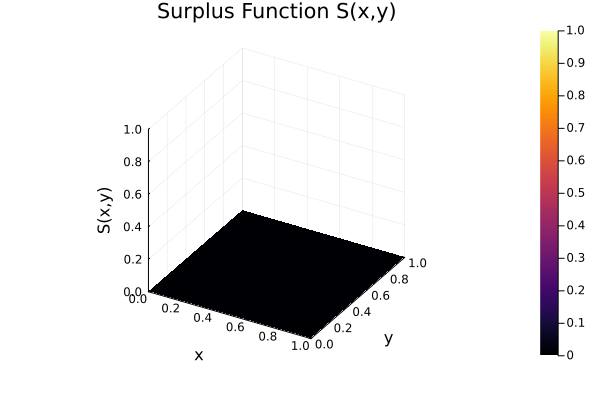

In [291]:
surface(grids.x_grid, grids.y_n_grid, state.S;
    xlabel = "x", ylabel = "y", zlabel = "S(x,y)",
    title = "Surplus Function S(x,y)")

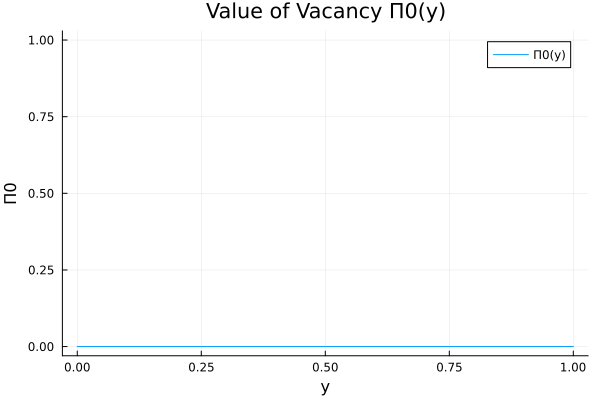

In [274]:
plot(grids.y_γ_grid, state.Π0, label="Π0(y)", xlabel="y", ylabel="Π0",
     title="Value of Vacancy Π0(y)", legend=:topright)

In [111]:
# === Step 4: Update κ ===
y0_idx = argmin(abs.(grids.y_n_grid .- 0.0))

# Denominator term 1: ∫ S(x,0)^+ u(x) dx
S_x0 = max.(state.S[:, y0_idx], 0.0)
term_den1 = sum(S_x0 .* state.u) * Δx

# Denominator term 2: ∬ [S(x,0) - S(x,y′)]^+ h(x,y′) dx dy′
ΔS = state.S[:, y0_idx] .- state.S
ΔS_pos = max.(ΔS, 0.0)
term_den2 = params.s * sum(ΔS_pos .* state.h) * Δx * Δy_n

# Numerator: c - δ ∫ Π₀(y') γ(y') dy'
γ_pdf = [dists.γ(y) for y in grids.y_γ_grid]
expectation_Π0 = sum(state.Π0 .* γ_pdf) * Δy_γ
numerator_κ = params.c - params.δ * expectation_Π0

# Final κ update
denominator_κ = term_den1 + term_den2
state.κ = numerator_κ / ((1 - params.β) * denominator_κ)

-7.142248413148076e65

N = 1.0103825140903706


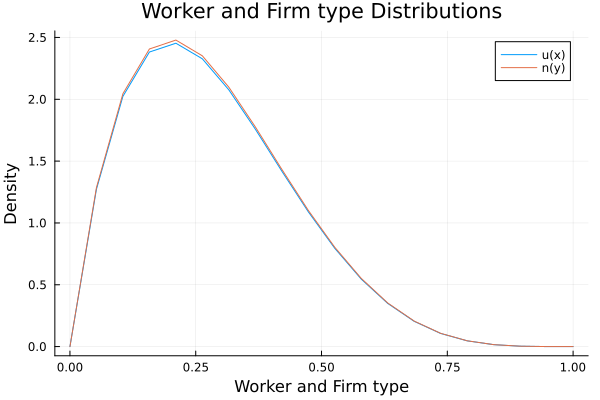

In [11]:
state = update_u_v_n(state, params, grids, dists)
N = state.N
println("N = $N")
# Plotting the distributions
plot(grids.x_grid, state.u, label="u(x)", xlabel="Worker and Firm type", ylabel="Density", title="Worker and Firm type Distributions")
plot!(grids.y_n_grid, state.n, label="n(y)")

In [12]:
state.κ

1.0

In [13]:
grids.y_n_grid

20-element Vector{Float64}:
 0.0
 0.05263157894736842
 0.10526315789473684
 0.15789473684210525
 0.21052631578947367
 0.2631578947368421
 0.3157894736842105
 0.3684210526315789
 0.42105263157894735
 0.47368421052631576
 0.5263157894736842
 0.5789473684210527
 0.631578947368421
 0.6842105263157895
 0.7368421052631579
 0.7894736842105263
 0.8421052631578947
 0.8947368421052632
 0.9473684210526315
 1.0

In [14]:
grids.y_γ_grid

20-element Vector{Float64}:
 0.0
 0.05263157894736842
 0.10526315789473684
 0.15789473684210525
 0.21052631578947367
 0.2631578947368421
 0.3157894736842105
 0.3684210526315789
 0.42105263157894735
 0.47368421052631576
 0.5263157894736842
 0.5789473684210527
 0.631578947368421
 0.6842105263157895
 0.7368421052631579
 0.7894736842105263
 0.8421052631578947
 0.8947368421052632
 0.9473684210526315
 1.0

In [15]:
function ces_utility(params,x,y)
    return (params.α * x^params.ρ + (1 - params.α) * y^params.ρ)^(1/params.ρ)
end

function b(params,x)
    return params.b * x
end

b (generic function with 1 method)

In [16]:
state, params, grids, dists = initialize_model(
    η=0.650,
    s=0.002,
    ξ=0.001,
    δ=0.007, 
    b=0.000,
    c=0.344,
    A=5.964,  
    α=0.607, 
    ρ=0.938,  
    aₓ=0.797, 
    bₓ=0.987, 
    a_y=1.988, 
    b_y=0.967,
    β=0.188,
    r=0.05,
    nx=50, 
    n_γ=50, 
    n_n=50
    )

state = update_u_v_n(state, params, grids, dists; tol=1e-6, max_iter=100, verbose=true)

ModelState([0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [33.156553427035085, 1.7369831165101286, 1.509403566860458, 1.3905296916552903, 1.3120240390039741, 1.2542841594530219, 1.2090713754822502, 1.172180764454125, 1.1411908364913297, 1.1145863598136705  …  0.8395148880046689, 0.8365972650178427, 0.8339612137420978, 0.831652065488336, 0.8297442085933631, 0.8283670450667332, 0.8277693031520835, 0.8285190110297015, 0.8324530752565684, 1.0013119074828452], [2.358770796394608e-16, 4.0463880069119263e-10, 8.031319292635296e-10, 1.19970170715681e-9, 1.5952462930611252e-9, 1.9902008692615663e-9, 2.3848301960563585e-9, 2.779317247924302e-9, 3.173799778583128e-9, 3.5683882877066045e-9  …  1.6364161398101933e-8, 1.6833598575216565e-8, 1.7315321083592212e-8, 1.7812969671871516e-8, 1.8332163411410795e-8, 1.888228157180508e-8, 1.9480864334989296e-8, 2.0167273098877106e-8, 2.1067588

In [17]:
state, params, grids, dists = initialize_model(
    η=0.650,
    s=0.002,
    ξ=0.001,
    δ=0.007, 
    b=0.000,
    c=0.344,
    A=5.964,  
    α=0.607, 
    ρ=0.938,  
    aₓ=0.797, 
    bₓ=0.987, 
    a_y=1.988, 
    b_y=0.967,
    β=0.188,
    r=0.05,
    nx=50, 
    n_γ=50, 
    n_n=50
    )

(ModelState([0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [33.156553427035085, 1.7369831165101286, 1.509403566860458, 1.3905296916552903, 1.3120240390039741, 1.2542841594530219, 1.2090713754822502, 1.172180764454125, 1.1411908364913297, 1.1145863598136705  …  0.8395148880046689, 0.8365972650178427, 0.8339612137420978, 0.831652065488336, 0.8297442085933631, 0.8283670450667332, 0.8277693031520835, 0.8285190110297015, 0.8324530752565684, 1.0013119074828452], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 1.0, 1.0, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0

In [18]:
dists.ℓ.(grids.x_grid)

50-element Vector{Float64}:
 33.156553427035085
  1.7369831165101286
  1.509403566860458
  1.3905296916552903
  1.3120240390039741
  1.2542841594530219
  1.2090713754822502
  1.172180764454125
  1.1411908364913297
  1.1145863598136705
  ⋮
  0.8365972650178427
  0.8339612137420978
  0.831652065488336
  0.8297442085933631
  0.8283670450667332
  0.8277693031520835
  0.8285190110297015
  0.8324530752565684
  1.0013119074828452

In [19]:
Δx = grids.x_grid[2] - grids.x_grid[1]
Δy = grids.y_n_grid[2] - grids.y_n_grid[1]

state.u .= max.(0.0, dists.ℓ.(grids.x_grid) .- sum(state.h, dims=2) .* Δy)

50-element Vector{Float64}:
 33.156553427035085
  1.7369831165101286
  1.509403566860458
  1.3905296916552903
  1.3120240390039741
  1.2542841594530219
  1.2090713754822502
  1.172180764454125
  1.1411908364913297
  1.1145863598136705
  ⋮
  0.8365972650178427
  0.8339612137420978
  0.831652065488336
  0.8297442085933631
  0.8283670450667332
  0.8277693031520835
  0.8285190110297015
  0.8324530752565684
  1.0013119074828452

In [112]:
function update_kappa_h_S!(state::ModelState, params::ModelParameters,
                           grids::ModelGrids, dists::ModelDistributions;
                           tol::Float64 = 1e-8, max_iter_Π0::Int = 100, verbose::Bool = false)

    Δx = grids.x_grid[2] - grids.x_grid[1]
    Δy_n = grids.y_n_grid[2] - grids.y_n_grid[1]
    Δy_γ = grids.y_γ_grid[2] - grids.y_γ_grid[1]
    nx = length(grids.x_grid)
    n_n = length(grids.y_n_grid)
    n_γ = length(grids.y_γ_grid)

    # === Step 1: Update h(x,y) ===
    h_new = similar(state.h)
    for x_idx in 1:nx
        S_row = view(state.S, x_idx, :)
        h_row = view(state.h, x_idx, :)
        h_total_x = sum(h_row) * Δy_n

        for y_idx in 1:n_n
            S_xy = S_row[y_idx]
            if S_xy < 0
                h_new[x_idx, y_idx] = 0.0
                continue
            end

            B_mask = (S_row .>= 0.0) .& (S_row .< S_xy)
            V̄_mask = .!B_mask

            h_B = sum(h_row[B_mask]) * Δy_n
            V_B̄ = sum(state.v[V̄_mask]) * Δy_n

            numer = params.δ * h_total_x + (state.u[x_idx] + params.s * h_B) * state.κ * state.v[y_idx]
            denom = params.δ + params.ξ + params.s * state.κ * V_B̄

            h_new[x_idx, y_idx] = denom > tol ? numer / denom : 0.0
        end
    end
    state.h .= h_new

    # === Step 2: Update S(x,y) ===
    S_new = similar(state.S)
    γ_pdf = [dists.γ(y) for y in grids.y_γ_grid]

    for ix in 1:nx
        S_row = view(state.S, ix, :)
        S_pos = max.(S_row, 0.0)
        f_row = [ces_utility(params, grids.x_grid[ix], y) for y in grids.y_n_grid]
        b_val = b(params, grids.x_grid[ix])
        u_x = state.u[ix]

        term1 = state.κ * params.β * sum(S_pos .* state.v) * Δy_n
        term5 = params.δ * sum(S_pos .* γ_pdf) * Δy_γ

        for iy in 1:n_n
            S_xy = S_row[iy]
            f_xy = f_row[iy]

            term2 = state.κ * (1 - params.β) * max(S_xy, 0.0) * u_x

            ΔS_mat = S_xy .- state.S
            ΔS_pos = max.(ΔS_mat, 0.0)
            term3 = params.s * state.κ * (1 - params.β) * sum(ΔS_pos .* state.h) * Δx * Δy_n

            ΔS_vec = max.(S_row .- S_xy, 0.0)
            term4 = params.β * params.s * state.κ * sum(ΔS_vec .* state.v) * Δy_n

            numerator = f_xy - b_val + params.c - term1 - term2 - term3 + term4 + term5
            denom = params.r + params.δ + params.ξ
            S_new[ix, iy] = numerator / denom
        end
    end
    state.S .= max.(S_new, 0.0)

    # === Step 3: Update Π₀ using fixed point iteration ===
    iterate_Π0!(state, params, grids, dists)

    # === Step 4: Update κ ===
    y0_idx = argmin(abs.(grids.y_n_grid .- 0.0))
    S_x0 = max.(state.S[:, y0_idx], 0.0)
    term_den1 = sum(S_x0 .* state.u) * Δx

    ΔS = state.S[:, y0_idx] .- state.S
    ΔS_pos = max.(ΔS, 0.0)
    term_den2 = params.s * sum(ΔS_pos .* state.h) * Δx * Δy_n

    expectation_Π0 = sum(state.Π0 .* γ_pdf) * Δy_γ
    numerator_κ = params.c - params.δ * expectation_Π0
    denominator_κ = term_den1 + term_den2
    state.κ = numerator_κ / ((1 - params.β) * denominator_κ)

    return state
end

update_kappa_h_S! (generic function with 1 method)

In [152]:
state, params, grids, dists = initialize_model(b=0.2, c=0.1, A=1.0, δ = 0.05, ξ = 0.1)

(ModelState([0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [2.9999998799999994e-7, 0.5637749875919217, 1.0364832353860496, 1.426571147123761, 1.7420110319116844, 1.9903138487011298, 2.178541950767517, 2.313321830189802, 2.4008568623299107, 2.44694005031216  …  0.027872176510586943, 0.01783547414449751, 0.010709823287915761, 0.005918536246692538, 0.002920609869079184, 0.0012234700251560796, 0.0003957160862614184, 7.986540441991122e-5, 5.0977917714836885e-6, 3.0000000302971166e-31], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 1.0, 1.0, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0

In [153]:
state = update_u_v_n(state, params, grids, dists; tol=1e-6, max_iter=100, verbose=false)
state = update_kappa_h_S!(state, params, grids, dists; verbose=false)

ModelState([0.5 0.5255102040816326 … 1.7244897959183674 1.7499999999999998; 0.5051020408163265 0.5816326530612245 … 2.0830715933814035 2.1122448979591835; … ; 0.7448979591836733 1.123887919912016 … 4.4183673469387745 4.46925625571064; 0.7499999999999999 1.1326530612244896 … 4.448848092445334 4.5], [1.3862240958706742e-13 2.605061679032842e-7 … 2.355560690676408e-12 1.3862241653191723e-37; 2.6050616790328415e-7 0.48955622483989286 … 4.426687507594535e-6 2.605061809543934e-31; … ; 2.3555606906764076e-12 4.426687507594536e-6 … 4.002719462162321e-11 2.3555608086877396e-36; 1.386224165319172e-37 2.605061809543934e-31 … 2.3555608086877396e-36 1.3862242347676736e-61], [2.9999998799999994e-7, 0.5637749875919217, 1.0364832353860496, 1.426571147123761, 1.7420110319116844, 1.9903138487011298, 2.178541950767517, 2.313321830189802, 2.4008568623299107, 2.44694005031216  …  0.027872176510586943, 0.01783547414449751, 0.010709823287915761, 0.005918536246692538, 0.002920609869079184, 0.00122347002515607

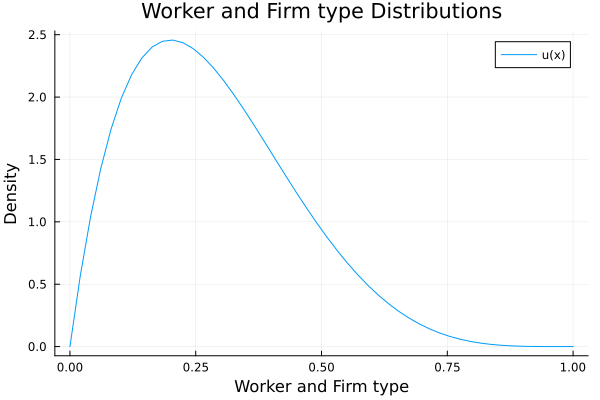

In [154]:
plot(grids.x_grid, state.u, label="u(x)", xlabel="Worker and Firm type", ylabel="Density", title="Worker and Firm type Distributions")

In [155]:
sum(state.u) * Δx

0.9989590335025788

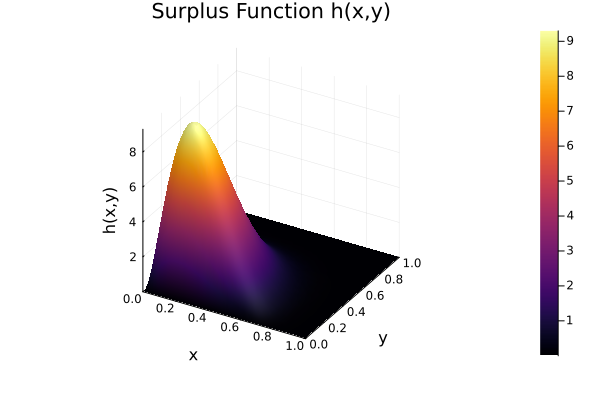

In [156]:
surface(grids.x_grid, grids.y_n_grid, state.h;
    xlabel = "x", ylabel = "y", zlabel = "h(x,y)",
    title = "Surplus Function h(x,y)")

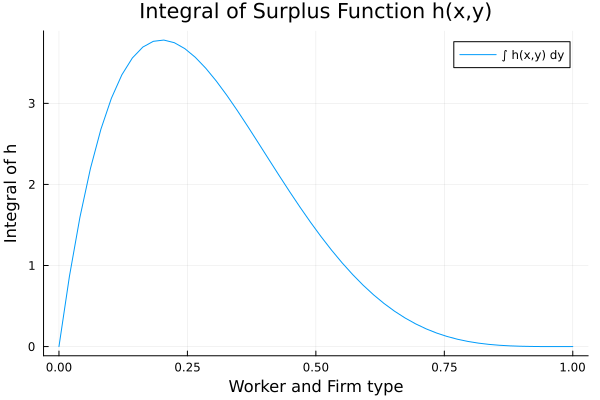

In [157]:
int_h = sum(state.h, dims=2) * Δy

plot(grids.x_grid, int_h, label="∫ h(x,y) dy", xlabel="Worker and Firm type", ylabel="Integral of h",
     title="Integral of Surplus Function h(x,y)")

In [160]:
int_int_h = sum(int_h) * Δx

1.5370440922027018

In [158]:
# Get grid spacing
Δx = grids.x_grid[2] - grids.x_grid[1]
Δy = grids.y_n_grid[2] - grids.y_n_grid[1]

# Step 1: Calculate u(x) and U
# u(x) = ℓ(x) - ∫h(x,y)dy
state.u .= dists.ℓ.(grids.x_grid) .- sum(state.h, dims=2) * Δy
U = sum(state.u) * Δx

-0.5380850587001232

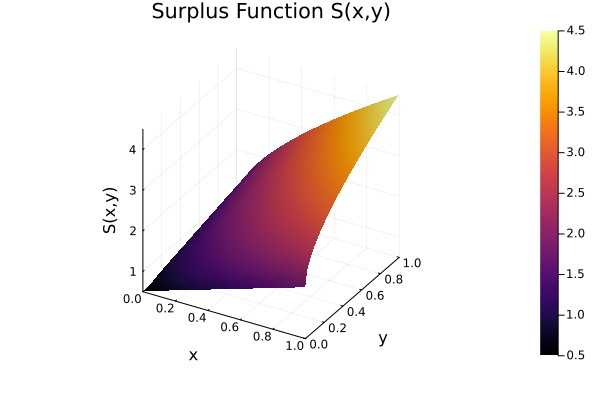

In [159]:
surface(grids.x_grid, grids.y_n_grid, state.S;
    xlabel = "x", ylabel = "y", zlabel = "S(x,y)",
    title = "Surplus Function S(x,y)")

In [25]:
function solve_model(state::ModelState, params::ModelParameters, grids::ModelGrids, dists::ModelDistributions;
                     tol=1e-6, max_outer_iter=50, max_inner_iter=100, verbose=false)

    for outer_it in 1:max_outer_iter
        κ_old = state.κ
        h_old = copy(state.h)
        S_old = copy(state.S)

        # Step 1: update u, v, n given current κ, h, S
        state = update_u_v_n(state, params, grids, dists; tol=tol, max_iter=max_inner_iter, verbose=verbose)

        # Step 2: update κ, h, S using new u, v, n
        state = update_kappa_h_S!(state, params, grids, dists; tol=tol, max_iter_Π0=max_inner_iter, verbose=verbose)

        # Check convergence
        κ_diff = abs(state.κ - κ_old)
        h_diff = maximum(abs.(state.h .- h_old))
        S_diff = maximum(abs.(state.S .- S_old))

        if verbose
            println("Outer iter $outer_it: κ diff = $κ_diff, h diff = $h_diff, S diff = $S_diff")
        end

        if κ_diff < tol && h_diff < tol && S_diff < tol
            if verbose
                println("Converged after $outer_it outer iterations.")
            end
            break
        end
    end

    # Final step: compute W₀(x) now that model has converged
    Δx = grids.x_grid[2] - grids.x_grid[1]
    Δy = grids.y_n_grid[2] - grids.y_n_grid[1]

    for x_idx in 1:length(grids.x_grid)
        b_val = b(params, grids.x_grid[x_idx])
        surplus_term = sum(max.(state.S[x_idx, :], 0.0) .* state.v) * Δy
        state.W0[x_idx] = (b_val + state.κ * params.β * surplus_term) / params.r
    end

    # Compute aggregate U and V
    U = sum(state.u) * Δx
    matches = U + params.s * max(0.0, 1 - U)
    V = (params.η^2) / (state.κ^2 * matches)

    return state, U, V
end

solve_model (generic function with 1 method)

In [26]:
state, params, grids, dists = initialize_model(
    η=0.650,
    s=0.002,
    ξ=0.001,
    δ=0.007, 
    b=0.000,
    c=0.344,
    A=5.964,  
    α=0.607, 
    ρ=0.938,  
    aₓ=0.797, 
    bₓ=0.987, 
    a_y=1.988, 
    b_y=0.967,
    β=0.188,
    r=0.05,
    nx=50, 
    n_γ=50, 
    n_n=50
    )
state, U, V = solve_model(state, params, grids, dists; verbose=false)

println("Final κ: ", state.κ)
println("Final U: ", U)
println("Final V: ", V)

Final κ: 1.0e-8
Final U: 0.0
Final V: 2.1125e18


In [27]:
state, params, grids, dists = initialize_model(
    η=0.425,
    s=0.157,
    ξ=0.004,
    δ=0.008, 
    b=0.000,
    c=1.575,
    A=7.541,  
    α=0.606, 
    ρ=-0.895,  
    aₓ=0.891, 
    bₓ=0.616, 
    a_y=1.034, 
    b_y=1.147,
    β=0.272,
    r=0.05,
    nx=50, 
    n_γ=50, 
    n_n=50
    )
state, U, V = solve_model(state, params, grids, dists; verbose=false)

println("Final κ: ", state.κ)
println("Final U: ", U)
println("Final V: ", V)

Final κ: 1.0e-8
Final U: 0.0
Final V: 1.1504777070063692e16


In [28]:
state, params, grids, dists = initialize_model(
    η=0.650,
    s=0.002,
    ξ=0.001,
    δ=0.007, 
    b=0.000,
    c=0.344,
    A=5.964,  
    α=0.607, 
    ρ=0.938,  
    aₓ=0.797, 
    bₓ=0.987, 
    a_y=1.988, 
    b_y=0.967,
    β=0.188,
    r=0.05,
    nx=50, 
    n_γ=50, 
    n_n=50
)

state = update_u_v_n(state, params, grids, dists)

@show state.κ
@show state.u
@show state.n
@show state.v

@assert all(isfinite, state.u) "NaN in u"
@assert all(isfinite, state.n) "NaN in n"
@assert all(isfinite, state.v) "NaN in v"

state.κ = 1.0
state.u = [33.156553427035085, 1.7369831165101286, 1.509403566860458, 1.3905296916552903, 1.3120240390039741, 1.2542841594530219, 1.2090713754822502, 1.172180764454125, 1.1411908364913297, 1.1145863598136705, 1.0913596510248318, 1.0708085528579006, 1.0524253920711384, 1.0358319442203614, 1.020739350071818, 1.006922352276979, 0.994202144340382, 0.9824346070734413, 0.9715020305278363, 0.9613071574991648, 0.951768813274203, 0.9428186439317667, 0.9343986451754968, 0.9264592653484311, 0.9189579326189604, 0.9118579005912175, 0.9051273367530724, 0.8987385991538188, 0.8926676616184194, 0.8868936586843319, 0.8813985296564723, 0.8761667476836738, 0.8711851253124371, 0.8664426932311267, 0.8619306545851797, 0.857642424238549, 0.8535737720755827, 0.8497231042506936, 0.8460919405304412, 0.8426856879327292, 0.8395148880046689, 0.8365972650178427, 0.8339612137420978, 0.831652065488336, 0.8297442085933631, 0.8283670450667332, 0.8277693031520835, 0.8285190110297015, 0.8324530752565684, 1.0

In [29]:
state, params, grids, dists = initialize_model(
    r = 0.05,         # Discount rate
    δ = 0.04,         # Separation rate
    ξ = 0.02,         # Exogenous exit rate
    β = 0.5,          # Matching elasticity
    b = 0.1,          # Unemployment benefit
    s = 0.1,          # On-the-job search
    η = 0.5,          # Matching efficiency
    c = 0.1,          # Vacancy posting cost
    ρ = 0.5,          # Utility function parameter
    α = 0.5,          # Utility function parameter
    A = 1.0,          # Productivity scale
    nx = 50,          # Grid points for worker type
    n_γ = 50,         # Grid points for firm type (gamma)
    n_n = 50,         # Grid points for firm type (n)
    aₓ = 2,           # Beta parameter for worker type
    bₓ = 5,           # Beta parameter for worker type
    a_y = 2,          # Beta parameter for firm type
    b_y = 5           # Beta parameter for firm type
)

U = sum(state.u) * Δx
println("U = ", U)

U = 0.9989590335025788


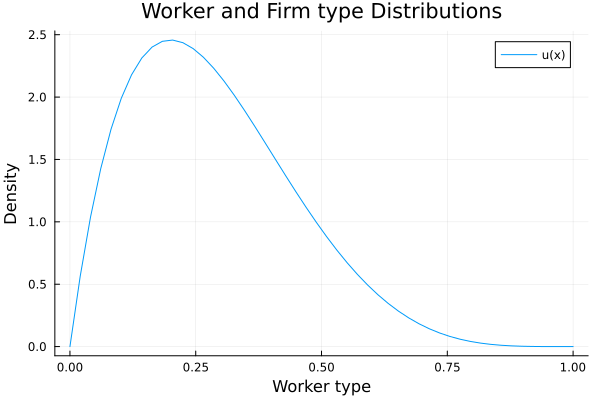

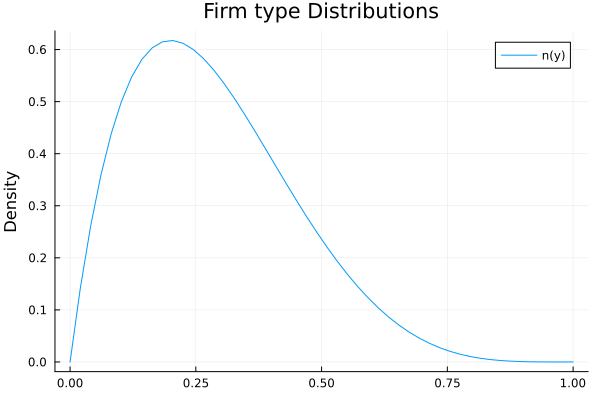

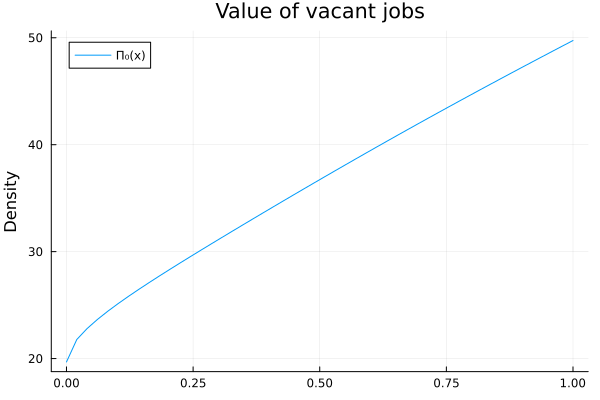

0.2512754035963901


In [30]:
state = update_u_v_n(state, params, grids, dists)
state = update_kappa_h_S!(state, params, grids, dists; verbose=true)
println(state.N)
u_plot = plot(grids.x_grid, state.u, label="u(x)", xlabel="Worker type", ylabel="Density", title="Worker and Firm type Distributions")
display(u_plot)
n_plot = plot(grids.y_n_grid, state.n, label="n(y)", ylabel="Density", title= "Firm type Distributions")
display(n_plot)
Π₀ = plot(grids.y_n_grid, state.Π0, label="Π₀(x)", ylabel="Density", title= "Value of vacant jobs")
display(Π₀)

In [31]:
state

ModelState([0.9090909090909092 0.9554730983302413 … 3.13543599257885 3.1818181818181817; 0.9369202226345084 1.0760667903525047 … 3.8059557727528306 3.85899814471243; … ; 2.2448979591836733 2.933970615053387 … 8.923933209647494 9.016458498323614; 2.272727272727273 2.968460111317254 … 8.997905622627881 9.090909090909092], [2.6573932881564255e-13 4.993906426613741e-7 … 4.515612726611113e-12 2.657393421289281e-37; 4.993906426613741e-7 0.9384798821056552 … 8.48596536915563e-6 4.993906676803663e-31; … ; 4.515612726611113e-12 8.48596536915563e-6 … 7.673218107237109e-11 4.51561295283898e-36; 2.657393421289281e-37 4.993906676803664e-31 … 4.51561295283898e-36 2.657393554422143e-61], [2.9999998799999994e-7, 0.5637749875919217, 1.0364832353860496, 1.426571147123761, 1.7420110319116844, 1.9903138487011298, 2.178541950767517, 2.313321830189802, 2.4008568623299107, 2.44694005031216  …  0.027872176510586943, 0.01783547414449751, 0.010709823287915761, 0.005918536246692538, 0.002920609869079184, 0.00122

In [32]:
state, params, grids, dists = initialize_model(
    η=0.650,
    s=0.002,
    ξ=0.002,
    δ=0.007, 
    b=0.000,
    c=0.344,
    A=5.964,  
    α=0.607, 
    ρ=0.938,  
    aₓ=2, 
    bₓ=5, 
    a_y=2, 
    b_y=5,
    β=0.4,
    r=0.05,
    nx=50, 
    n_γ=50, 
    n_n=50
    )
state, U, V = solve_model(state, params, grids, dists; verbose=false)

println("Final κ: ", state.κ)
println("Final U: ", U)
println("Final V: ", V)

Final κ: 1.0e-8
Final U: 0.0
Final V: 2.1125e18


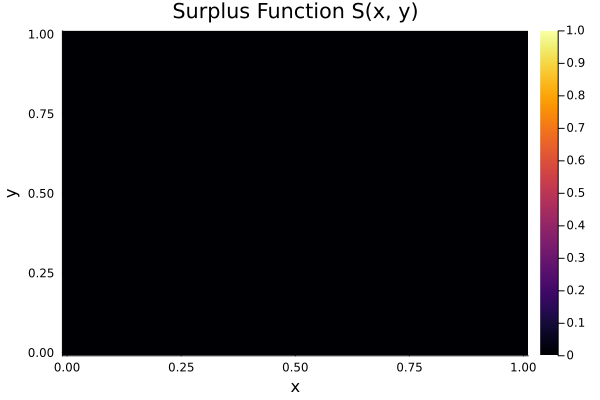

In [33]:
# Heatmap of S(x, y)
heatmap(grids.x_grid, grids.y_n_grid, state.S'; 
    xlabel = "x", ylabel = "y", 
    title = "Surplus Function S(x, y)",
    colorbar = true,
    legend = false)

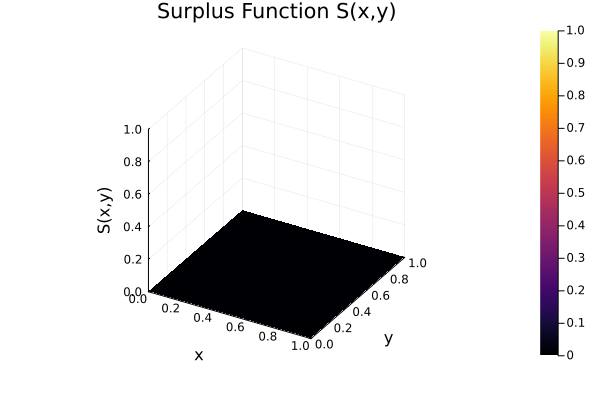

In [34]:
surface(grids.x_grid, grids.y_n_grid, state.S;
    xlabel = "x", ylabel = "y", zlabel = "S(x,y)",
    title = "Surplus Function S(x,y)")

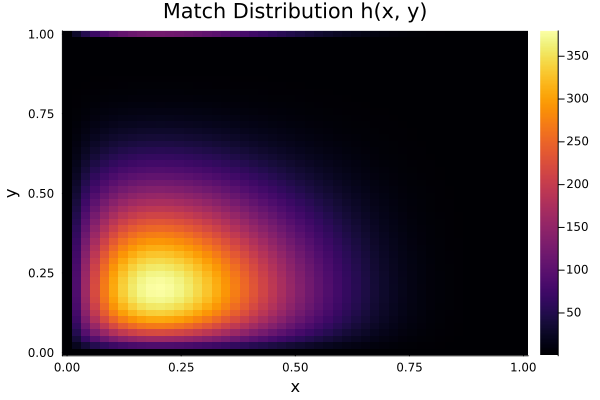

In [35]:
# heatmap of h(x, y)
heatmap(grids.x_grid, grids.y_n_grid, state.h'; 
    xlabel = "x", ylabel = "y", 
    title = "Match Distribution h(x, y)",
    colorbar = true,
    legend = false)

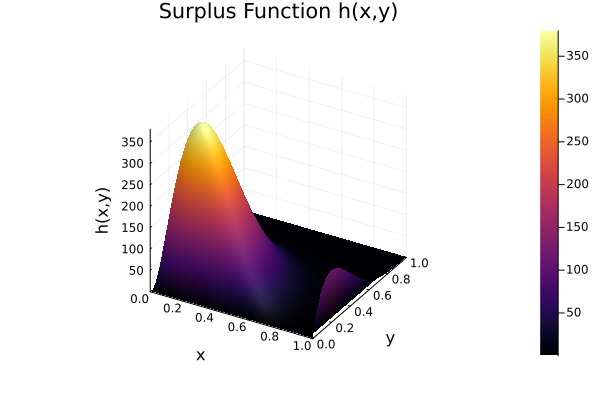

In [36]:
surface(grids.x_grid, grids.y_n_grid, state.h;
    xlabel = "x", ylabel = "y", zlabel = "h(x,y)",
    title = "Surplus Function h(x,y)")

In [37]:
state.u

50-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

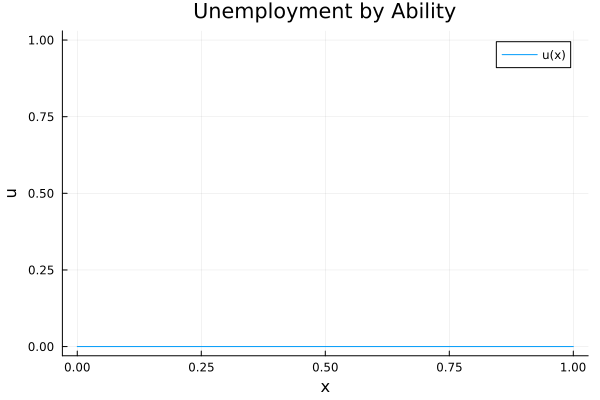

In [38]:
# Line plot for u(x)
plot(grids.x_grid, state.u; 
    label = "u(x)", 
    xlabel = "x", 
    ylabel = "u", 
    title = "Unemployment by Ability")

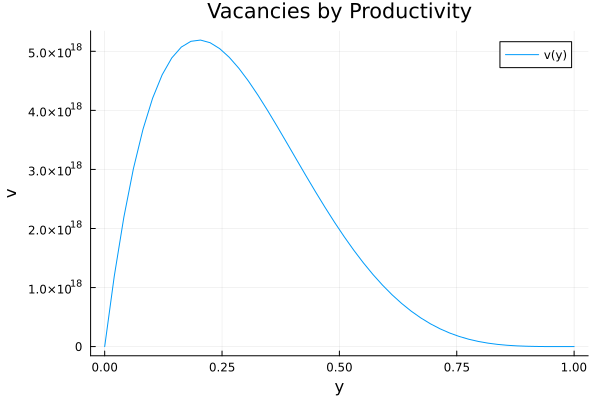

In [39]:
# Line plot for v(y)
plot(grids.y_n_grid, state.v; 
    label = "v(y)", 
    xlabel = "y", 
    ylabel = "v", 
    title = "Vacancies by Productivity")

In [40]:
state.v

50-element Vector{Float64}:
 6.337499746499999e11
 1.1909746612879345e18
 2.1895708347530296e18
 3.013631548298945e18
 3.679998304913433e18
 4.204538005381137e18
 4.60216987099638e18
 4.886892366275957e18
 5.071810121671936e18
 5.169160856284438e18
 ⋮
 3.767743913025099e16
 2.2624501695722044e16
 1.2502907821137986e16
 6.169788348429776e15
 2.584580428142218e15
 8.359502322272464e14
 1.6871566683706247e14
 1.0769085117259291e13
 0.0

In [41]:
function unpack_params(p)
    return (
        δ = p[1], ξ = p[2], β = p[3], b = p[4], s = p[5], η = p[6], c = p[7],
        ρ = p[8], α = p[9], A = p[10], aₓ = p[11], bₓ = p[12], a_y = p[13], b_y = p[14]
    )
end

function smm_objective(p, U_target)
    try
        fixed = (r=0.05, nx=50, n_γ=50, n_n=50)
        kwargs = merge(unpack_params(p), fixed)
        state, params, grids, dists = initialize_model(; kwargs...)
        state, U, V = solve_model(state, params, grids, dists; verbose=false)
        return (U - U_target)^2
    catch err
        #@warn "Parameter set failed with error: $err"
        return 1e6  # Large penalty
    end
end


smm_objective (generic function with 1 method)

In [42]:
using Optim

# Parameter names and bounds
param_names = ["δ", "ξ", "β", "b", "s", "η", "c", "ρ", "α", "A", "aₓ", "bₓ", "a_y", "b_y"]
lower_bounds = [0.00001, 0.000001, 0.01, 0.0, 0.0001, 0.0001, 0.00001, -10.0, 0.01, 0.1, 0.001, 0.001, 0.001, 0.001]
upper_bounds = [0.4,  0.4,   0.5,  15.0, 5.0,  10.0, 15.0,  10.0,  1.0, 10.0, 10.0, 10.0, 10.0, 10.0]

# Initial guess
p0 = [0.01, 0.01, 0.3, 0.05, 0.2, 0.5, 1.0, 0.0, 0.5, 5.0, 2.0, 5.0, 2.0, 5.0]

# Objective function (replace with your own)
U_target = 0.5
function smm_objective(p)
    return (sum(p) - U_target)^2
end

# Run Simulated Annealing with bounds using SAMIN
result = optimize(
    smm_objective,
    lower_bounds,
    upper_bounds,
    p0,
    SAMIN(),
    Optim.Options(iterations=20_000_000) 
)

# Print results
best_params = Optim.minimizer(result)
println("\nBest parameters found:")
for (i, name) in enumerate(param_names)
    println("  $name = $(round(best_params[i], digits=4))")
end
println("Minimized objective: ", round(Optim.minimum(result), digits=8))



Best parameters found:
  δ = 0.069
  ξ = 0.1128
  β = 0.17
  b = 0.9907
  s = 2.0444
  η = 1.4067
  c = 0.1282
  ρ = -9.2724
  α = 0.9325
  A = 1.4231
  aₓ = 0.0915
  bₓ = 1.0301
  a_y = 1.3395
  b_y = 0.0339
Minimized objective: 0.0


In [43]:

kwargs = merge(unpack_params(best_params), (r=0.05, nx=50, n_γ=50, n_n=50))
state, params, grids, dists = initialize_model(; kwargs...)
state, U, V = solve_model(state, params, grids, dists; verbose=false)


println("Final κ: ", state.κ)
println("Final U: ", U)
println("Final V: ", V)

Final κ: NaN
Final U: 34745.11852551991
Final V: NaN
